This notebook runs the RBM emulator by using the existing Skyrme DFT software and passes arrays back and forth to that module.

In [2]:
import numpy as np
from scipy import optimize, linalg
from scipy.stats import qmc
import os
import subprocess
from contextlib import contextmanager
import time
import matplotlib.pyplot as plt
import math
from multiprocess import Pool
import random
import json
from copy import deepcopy
import skyrme_hpsi
rootdir = os.getcwd()

Next up are the common functions for all the Skyrme DFT notebooks -- you can ignore most of this as it's not used for the production runs.

In [3]:
@contextmanager
def cwd(path):
    oldpwd=os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

def spin(spin):
    if(spin==1): return -0.5
    return 0.5

def make_input(params,restart,directory):
    in_template = "../HF/in.template"
    f1 = open(in_template, 'r')
    
    int_string = "&interaction t0={t0},x0={x0},t1={t1},x1={x1},t2={t2},x2={x2},t3={t3},x3={x3},w0={w0},sig={sig},icoul=1,icm=1,j2terms=.true. / \n".format(\
    t0=params["t0"],x0=params["x0"],t1=params["t1"],x1=params["x1"],t2=params["t2"],x2=params["x2"],t3=params["t3"],x3=params["x3"],w0=params["w0"],sig=params["sig"])
    if(restart):
        io_string = "&io printwf=F,printdens=F,restartwf=T,printhpsi=T /"
    else:
        io_string = "&io printwf=T,printdens=F,restartwf=F,printhpsi=F /"
    in_out = directory+"/in"
    f2 = open(in_out, 'w')
    f1.seek(0)
    f2.write(f1.read())
    f2.write(int_string)
    f2.write(io_string)
    f2.write("\n")

    f1.close()
    f2.close()

    return

def run_HF(tag,restart):
    noNaN = 1
    neut = 0
    if(restart == 0):
        os.system("cp in results/in."+tag)
        #print(os.system("../HF/./main"))
        output = subprocess.run(["./main"], capture_output=True)
        #print(output)
        #print(subprocess.run("../HF/./main",shell=True))
        os.system("mv out results/out."+tag)
        os.system("mv wf_numpy.bin results/wf_numpy.bin."+tag)
        noNaN = os.system("grep -q NaN results/out."+tag)
        neut = os.system('grep -q "Total Neutrons =   28.000" results/out.'+tag)
        neut = neut+os.system('grep -q "Total Neutrons =   27.999" results/out.'+tag)
    else:
        output = subprocess.run(["./main"], capture_output=True)
        #os.system("mv out results/out_rst."+tag)
        #os.system("mv hpsi.bin results/hpsi.bin."+tag)
        #print(output)
        #noNaN = os.system("grep -q NaN results/out_rst."+tag)
    if (noNaN == 0):
        print("NaNs in run {tag}!".format(tag=tag))
        return 1
    if(neut > 256):
        print("Wrong number of neutrons in run {tag}!".format(tag=tag))
        return 1

    return 0


def read_wfs(restartfile):
    #restartfile = '../HF/wf_numpy.bin'

    intchunk = np.dtype(np.int32).itemsize
    realchunk = np.dtype(np.float64).itemsize
    h = np.fromfile(restartfile, dtype=np.float64, count=1, offset=0)[0]
    nbox = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(realchunk+0*intchunk))[0]
    lmax = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(realchunk+1*intchunk))[0]
    nmax = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(realchunk+2*intchunk))[0]
#     print("hbox = ", h)
#     print("nbox = ",nbox)
#     print("lmax = ",lmax)
#     print("nmax = ",nmax)

    #sortstates, sortenergies, wfr,
    sortstatest = np.fromfile(restartfile, dtype=np.int32, count=nmax*3*2, offset=(realchunk+3*intchunk)).reshape(2,3,nmax)
    sortenergiest = np.fromfile(restartfile, dtype=np.float64, count=nmax*2, offset=(realchunk+3*intchunk+nmax*3*2*intchunk)).reshape(2,nmax)
    wft = np.fromfile(restartfile, dtype=np.float64, count=2*2*(lmax+1)*lmax*(nbox+1), offset=(realchunk+3*intchunk+nmax*3*2*intchunk+sortenergiest.nbytes)).reshape(2,2,(lmax+1),lmax,(nbox+1))
    wfs = np.zeros(((nbox+1),lmax,(lmax+1),2,2))
    sortstates = np.zeros((nmax,3,2),np.int8)
    sortenergies = np.zeros((nmax,2))
    for iq in range(2):
        for i_s in range(2):
            for i_l in range(lmax+1):
                for i_n in range(lmax):
                    for i_r in range(nbox+1):
                        wfs[i_r,i_n,i_l,i_s,iq] = wft[iq,i_s,i_l,i_n,i_r]
        for i in range(nmax):
            sortenergies[i,iq] = sortenergiest[iq,i]
            for i_s in range(3):
                sortstates[i,i_s,iq] = sortstatest[iq,i_s,i]
    #sortenergies = sortenergiest.reshape(2,nmax,order='F')#np.asfortranarray(sortenergiest)
    return h,nbox,lmax,nmax,sortstates,sortenergies,wfs

def print_wfs(restartfile,h,nbox,lmax,nmax,sortstates,sortenergies,wfs):
    with open(restartfile, 'wb') as file:
        file.write(h)
        file.write(nbox)
        file.write(lmax)
        file.write(nmax)
        file.write(sortstates.reshape((nmax*3*2,)))
        file.write(sortenergies.reshape((nmax*2,)))
        file.write(wfs.reshape((2*2*(lmax+1)*lmax*(nbox+1),)))

    return

def read_hpsi(restartfile):

    intchunk = np.dtype(np.int32).itemsize

    nbox = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(0*intchunk))[0]
    lmax = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(1*intchunk))[0]
    nmax = np.fromfile(restartfile, dtype=np.int32, count=1, offset=(2*intchunk))[0]

    sortenergies = np.fromfile(restartfile, dtype=np.float64, count=nmax*2, offset=(3*intchunk)).reshape(2,nmax)
    hpsi = np.fromfile(restartfile, dtype=np.float64, count=2*2*(lmax+1)*lmax*(nbox+1), offset=(3*intchunk+sortenergies.nbytes)).reshape(2,2,(lmax+1),lmax,(nbox+1))

    return sortenergies,hpsi

def get_hpsi(params,h,nbox,lmax,nmax,sortstates,sortenergies,wf,directory):
    restartfile = directory+'/wf_numpy.bin'
    print_wfs(restartfile,h,nbox,lmax,nmax,sortstates,sortenergies,wf)

    make_input(params,1,directory)
    #with cwd('../HF/'):
    oldpwd=os.getcwd()

    os.chdir(directory)

    errors = run_HF("None",1)
    os.chdir(oldpwd)

    restartfile = directory+'/hpsi.bin'
    sortenergies,hpsi = read_hpsi(restartfile)

    return hpsi

def get_hpsi_fort(params,h,nbox,lmax,nmax,sortstates,sortenergies,wf,directory):
    hpsi = np.asfortranarray(np.zeros(wf.shape))
    t0 = params["t0"]
    t1 = params["t1"]
    t2 = params["t2"]
    t3 = params["t3"]
    x0 = params["x0"]
    x1 = params["x1"]
    x2 = params["x2"]
    x3 = params["x3"]
    w0 = params["w0"]
    sig = params["sig"]
    j2terms = True
    icoul = 1
    icm = 1
    skyrme_hpsi.gethpsi(h, nbox, lmax, nmax, sortstates, sortenergies, wf, hpsi, \
        t0,x0,t1,x1,t2,x2,t3,x3,sig,w0,j2terms,icoul,icm)
    hpsi[0,:,:,:,:] = 0.0

    return hpsi

# dwfr, ddwfr, &
# rho, tau, jsc, drho, ddrho, dtau, djsc, laprho,

def make_wf(coeffs,train_wfs,states,levels):
    train_num = len(train_wfs)
    tot_levels = sum(levels)
    trial_wf = np.zeros(train_wfs[0].shape)

    for i in range(train_num):
        for isospin in range(2):
            for j in range(levels[isospin]):
                i_s = states[j,2,isospin]-1
                i_l = states[j,1,isospin]
                i_n = states[j,0,isospin]-1
                # trial_wf[isospin,i_s,i_l,i_n,:] = trial_wf[isospin,i_s,i_l,i_n,:] \
                #     + train_wfs[i][isospin,i_s,i_l,i_n,:] * coeffs[i*tot_levels + isospin*levels[0] + j]
                trial_wf[:,i_n,i_l,i_s,isospin] = trial_wf[:,i_n,i_l,i_s,isospin] \
                    + train_wfs[i][:,i_n,i_l,i_s,isospin] * coeffs[i*tot_levels + isospin*levels[0] + j]
    return trial_wf

def make_dens(coeffs,train_dens,states,levels):
    train_num = len(train_wfs)
    tot_levels = sum(levels)
    trial_dens = np.zeros((train_dens[0].shape[0],4))

    for i in range(train_num):
        for isospin in range(2):
            for j in range(levels[isospin]):
                i_s = states[j,2,isospin]-1
                i_l = states[j,1,isospin]
                i_n = states[j,0,isospin]-1
                # trial_wf[isospin,i_s,i_l,i_n,:] = trial_wf[isospin,i_s,i_l,i_n,:] \
                #     + train_wfs[i][isospin,i_s,i_l,i_n,:] * coeffs[i*tot_levels + isospin*levels[0] + j]
                trial_dens[:,isospin] = trial_dens[:,isospin] \
                    + train_dens[i][:,i_n,i_l,i_s,isospin] * coeffs[i*tot_levels + isospin*levels[0] + j]
    trial_dens[:,2] =  trial_dens[:,0] +  trial_dens[:,1]
    trial_dens[:,3] =  trial_dens[:,0] -  trial_dens[:,1]
    return trial_wf

def make_partials(params,h,nbox,lmax,nmax,sortstates,sortenergies,wf):
    mesh = np.linspace(0, h*(nbox+1), nbox+1)
    mesh[0] = 1e-25
    t0 = params["t0"]
    t1 = params["t1"]
    t2 = params["t2"]
    t3 = params["t3"]
    x0 = params["x0"]
    x1 = params["x1"]
    x2 = params["x2"]
    x3 = params["x3"]
    w0 = params["w0"]
    sig = params["sig"]
    sig = 1.0/sig
    e2 = 1.4399784
    pi = 3.141592653589793
    hbar = 6.582119e-22
    hbar22m=20.73553
    A = 48.0
    cmcorr = 1.0 - (1.0/A)

    rho = np.zeros(wf.shape)
    tau = np.zeros(wf.shape)
    jsc = np.zeros(wf.shape)
    jsc = np.zeros(wf.shape)
    jsc = np.zeros(wf.shape)
    for iq in range(2):

        for i in range(nmax):
            if(sortstates[iq,2,i]<1):continue
            if (sortenergies[iq,i] < - 1e-25):
                n = sortstates[iq,0,i]-1
                l = sortstates[iq,1,i]
                s = sortstates[iq,2,i]-1
                j = sortstates[iq,1,i] + spin(sortstates[iq,2,i])
                if (sortstates[iq,1,i] == 0): j = 0.5
                #print(iq,s,l,n)
                dwf = derivative_sca(wf[iq,s,l,n,1:],nbox,l)
                '''
                for ir in range(1,nbox):
                    tau[:,:,:,:,ir] = tau[:,:,:,:,ir] + (2*j+1)*((dwf[ir]\
                    -wf[iq,s,l,n,ir]/mesh[ir])**2+l*(l+1)*(wf[iq,s,l,n,ir]**2)\
                     /mesh[ir]**2)/(4*pi*mesh[ir]**2)

                    rho[ir,iq] = rho[ir,iq] + (2*j+1)*wf[iq,s,l,n,ir]\
                    *wf[iq,s,l,n,ir] / (4*pi*mesh[ir]**2)

                    jsc[ir,iq] = jsc[ir,iq] + (2*j+1)*(j*(j+1)-l*(l+1)-0.75)\
                    *wf[iq,s,l,n,ir]**2/(4*pi*mesh[ir]**3)
                '''

                tau[1:,iq] = tau[1:,iq] + (2*j+1)*((dwf[:]\
                -wf[iq,s,l,n,1:]/mesh[1:])**2+l*(l+1)*(wf[iq,s,l,n,1:]**2)\
                /mesh[1:]**2)/(4*pi*mesh[1:]**2)

                rho[1:,iq] = rho[1:,iq] + (2*j+1)*wf[iq,s,l,n,1:]\
                *wf[iq,s,l,n,1:] / (4*pi*mesh[1:]**2)

                jsc[1:,iq] = jsc[1:,iq] + (2*j+1)*(j*(j+1)-l*(l+1)-0.75)\
                *wf[iq,s,l,n,1:]**2/(4*pi*mesh[1:]**3)
                rho[0,iq] = rho[1,iq]
                tau[1,iq] = tau[2,iq]
                tau[0,iq] = tau[1,iq]


    # rho[:,2]=rho[:,0] + rho[:,1]
    # rho[0,2] = rho[1,2]
    # rho[:,3]=rho[:,0] - rho[:,1]
    # tau[:,2]=tau[:,0] + tau[:,1]
    # tau[:,3]=tau[:,0] - tau[:,1]
    # jsc[:,2]=jsc[:,0] + jsc[:,1]
    # jsc[:,3]=jsc[:,0] - jsc[:,1]

    djsc = np.zeros(jsc.shape)
    drho = np.zeros(rho.shape)
    ddrho = np.zeros(rho.shape)
    laprho = np.zeros(rho.shape)

    for iq in range(2):
        for ir in range(nbox+1):
            if(ir < 1):
                djsc[:,:,:,:,ir] = (-jsc[ir+2,:,:,:,:] + 8*jsc[ir+1,iq] \
                 +8*jsc[ir+1,iq] - jsc[ir+2,iq])/(12*h)

                drho[:,:,:,:,ir] = (-rho[ir+2,iq] + 8*rho[ir+1,iq] \
                 -8*rho[ir+1,iq] + rho[ir+2,iq])/(12*h)

                ddrho[:,:,:,:,ir] = (-rho[ir+2,iq]+16*rho[ir+1,iq]-30*rho[:,:,:,:,ir]\
                 +16*rho[ir+1,iq]-rho[ir+2,iq])/(12*h**2)
            elif (ir < 2):
                djsc[:,:,:,:,ir] = (-jsc[ir+2,iq] + 8*jsc[ir+1,iq] \
                 +8*jsc[ir-1,iq] - jsc[:,:,:,:,ir])/(12*h)

                drho[:,:,:,:,ir] = (-rho[ir+2,iq] + 8*rho[ir+1,iq] \
                 -8*rho[ir-1,iq] + rho[:,:,:,:,ir])/(12*h)

                ddrho[:,:,:,:,ir] = (-rho[ir+2,iq]+16*rho[ir+1,iq]-30*rho[:,:,:,:,ir]\
                 +16*rho[ir-1,iq]-rho[:,:,:,:,ir])/(12*h**2)
            elif ((ir >= 2) and (ir <= nbox-2)):
                drho[:,:,:,:,ir] = (-rho[ir+2,iq] + 8*rho[ir+1,iq] \
                 -8*rho[ir-1,iq] + rho[ir-2,iq])/(12*h)

                djsc[:,:,:,:,ir] = (-jsc[ir+2,iq] + 8*jsc[ir+1,iq] \
                 -8*jsc[ir-1,iq] + jsc[ir-2,iq])/(12*h)

                ddrho[:,:,:,:,ir] = (-rho[ir+2,iq]+16*rho[ir+1,iq]-30*rho[:,:,:,:,ir]\
                 +16*rho[ir-1,iq]-rho[ir-2,iq])/(12*h**2)
            elif ((ir > nbox-2) and (ir!=nbox)):
                drho[:,:,:,:,ir] = 0.
                ddrho[:,:,:,:,ir] = 0.
                djsc[:,:,:,:,ir] = 0.
            else:
                drho[:,:,:,:,ir] = 0.
                ddrho[:,:,:,:,ir] = 0.
                djsc[:,:,:,:,ir] = 0.
        ddrho[:,:,:,:,0:3]=ddrho[:,:,:,:,4]

    # drho[:,2] = drho[:,0] + drho[:,1]
    # drho[:,3] = drho[:,0] - drho[:,1]
    # djsc[:,2] = djsc[:,0] + djsc[:,1]
    # djsc[:,3] = djsc[:,0] - djsc[:,1]
    # ddrho[:,2] = ddrho[:,0] + ddrho[:,1]
    # ddrho[:,3] = ddrho[:,0] - ddrho[:,1]
    for i in range(4):
        laprho[:,i] = ddrho[:,i] + 2./mesh[:]*drho[:,i]
    return dwfr, ddwfr, rho, tau, jsc, drho, ddrho, djsc, laprho

def galerkin(coeffs,train_wfs,states,levels,params,directory):
    
    #global count
    #global prev_time
    
    #count += 1
    #print("Iteration {}".format(count))
    #print("Iteration time: {}".format(time.time() - prev_time))
    
    #prev_time = time.time()
    
    results = np.zeros(coeffs.shape)
    
    train_num = len(train_wfs)
    tot_levels = sum(levels)
    
    trial_wf = make_wf(coeffs,train_wfs,states,levels)

    hpsi = get_hpsi_fort(params,h,nbox,lmax,nmax,states,sortenergies,trial_wf,directory)
    #hpsi = compute_hpsi(params,h,nbox,lmax,nmax,sortstates,sortenergies,trial_wf)
    for i in range(train_num):
        for isospin in range(2):
            for j in range(levels[isospin]):
                i_s = states[j,2,isospin]-1
                i_l = states[j,1,isospin]
                i_n = states[j,0,isospin]-1
                ele = i*tot_levels + isospin*levels[0] + j
                lam = coeffs[train_num*tot_levels + isospin*levels[0] + j]
                results[ele] = h*np.dot(train_wfs[i][:,i_n,i_l,i_s,isospin],hpsi[:,i_n,i_l,i_s,isospin]) \
                    - lam*h*np.dot(train_wfs[i][:,i_n,i_l,i_s,isospin],trial_wf[:,i_n,i_l,i_s,isospin])
                # print(isospin,i_s,i_l,i_n)
                # print(hpsi[isospin,i_s,i_l,i_n,:300])
                # print("i={} dot hpsi: {}".format(i,np.dot(train_wfs[i][isospin,i_s,i_l,i_n,:],hpsi[isospin,i_s,i_l,i_n,:])))
                # print("i={} dot trial: {}".format(i,np.dot(train_wfs[i][isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:])))
                # print("i={} dot i: {}".format(i,np.dot(train_wfs[i][isospin,i_s,i_l,i_n,:],train_wfs[i][isospin,i_s,i_l,i_n,:])))


    for isospin in range(2):
        for j in range(levels[isospin]):
            i_s = states[j,2,isospin]-1
            i_l = states[j,1,isospin]
            i_n = states[j,0,isospin]-1
            ele = train_num*tot_levels + isospin*levels[0] + j
            results[ele] = h*np.dot(trial_wf[:,i_n,i_l,i_s,isospin],trial_wf[:,i_n,i_l,i_s,isospin]) - 1.0
    #print(results)
    #print(coeffs)
    #if(count%100 == 0):print(results)
    #if(count%100 == 0):print(coeffs)
            
    return results
def galerkin_min(coeffs,train_wfs,states,levels,params,directory):
    
    global count
    #global prev_time
    
    count += 1
    print("Iteration {}".format(count))
    #print("Iteration time: {}".format(time.time() - prev_time))
    
    #prev_time = time.time()
    
    results = np.zeros(coeffs.shape)
    
    train_num = len(train_wfs)
    tot_levels = sum(levels)
    
    trial_wf = make_wf(coeffs,train_wfs,states,levels)

    hpsi = get_hpsi(params,h,nbox,lmax,nmax,states,sortenergies,trial_wf,directory)
    #hpsi = compute_hpsi(params,h,nbox,lmax,nmax,sortstates,sortenergies,trial_wf)
    for i in range(train_num):
        for isospin in range(2):
            for j in range(levels[isospin]):
                i_s = states[j,2,isospin]-1
                i_l = states[j,1,isospin]
                i_n = states[j,0,isospin]-1
                ele = i*tot_levels + isospin*levels[0] + j
                lam = coeffs[train_num*tot_levels + isospin*levels[0] + j]
                results[ele] = h*np.dot(train_wfs[i][isospin,i_s,i_l,i_n,:],hpsi[isospin,i_s,i_l,i_n,:]) \
                    - lam*h*np.dot(train_wfs[i][isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:])


    for isospin in range(2):
        for j in range(levels[isospin]):
            i_s = states[j,2,isospin]-1
            i_l = states[j,1,isospin]
            i_n = states[j,0,isospin]-1
            ele = train_num*tot_levels + isospin*levels[0] + j
            results[ele] = h*np.dot(trial_wf[isospin,i_s,i_l,i_n,:],trial_wf[isospin,i_s,i_l,i_n,:]) - 1.0
    if(count%100 == 0):print(coeffs)
    if(count%100 == 0):print(results)
            
    return np.sum(results[:]**2)
def galerkin_wrapper(coeffs,train_wfs,sortstates,levels,params,directory):
    hybr_dict = {'col_deriv': 0, 'xtol': 1.49012e-30,'maxfev': 10000, 'band': None, 'eps': None, 'factor': 10, 'diag': None}
    sol = optimize.root(galerkin, coeffs, args=(train_wfs,sortstates,levels,params,directory), method='hybr', options=hybr_dict)
    return sol

def hf_wrapper(params,directory):
    make_input(params,0,directory)
    with cwd(directory):
        errors = run_HF("test",0)
    return errors

def compute_hpsi(params,h,nbox,lmax,nmax,sortstates,sortenergies,wf):
    mesh = np.linspace(0, h*(nbox+1), nbox+1)
    mesh[0] = 1e-25
    t0 = params["t0"]
    t1 = params["t1"]
    t2 = params["t2"]
    t3 = params["t3"]
    x0 = params["x0"]
    x1 = params["x1"]
    x2 = params["x2"]
    x3 = params["x3"]
    w0 = params["w0"]
    sig = params["sig"]
    sig = 1.0/sig
    e2 = 1.4399784
    pi = 3.141592653589793
    hbar = 6.582119e-22
    hbar22m=20.73553
    A = 48.0
    cmcorr = 1.0 - (1.0/A)
    a0r0 = 3.0/8.0 * t0
    a1r1 = - 1.0/4.0 * t0 * ( 1.0/2.0 + x0 )
    a0s0 = - 1.0/4.0 * t0 * ( 1.0/2.0 - x0 )
    a1s1 = - 1.0/8.0 * t0
    
    a0tau0 = 3.0/16.0 * t1 + 1.0/4.0 * t2 * ( 5.0/4.0 + x2 )
    a1tau1 = - 1.0/8.0 * t1 * ( 1.0/2.0 + x1 ) + \
            1.0/8.0 * t2 * ( 1.0/2.0 + x2 )
    
    a0t0 = - 1.0/8.0 *t1* ( 1.0/2.0 - x1 ) + \
            1.0/8.0 * t2 * ( 1.0/2.0 + x2 )
    a1t1 =  1.0/16.0 * (t2-t1)
    
    a0r0p = - 9.0/64.0 * t1 + 1.0/16.0 * t2 *( 5.0/4.0 + x2 )
    a1r1p = 3.0/32.0 * t1 * ( 1.0/2.0 + x1 ) + \
            1.0/32.0 * t2 * ( 1.0/2.0 + x2 )

    a0s0p = 3.0/32.0 * t1 * ( 1.0/2.0 - x1 ) + \
            1.0/32.0 * t2 * ( 1.0/2.0 + x2 )
    a1s1p = 3.0/64.0 * t1 + 1.0/64.0 * t2
    
    cddr0 =  t3 / 16.00
    cddr1 = - 1.0/24.0 * t3 * ( 1.0/2.0 + x3 )
    cdds0 = - 1.0/24.0 * t3 * ( 1.0/2.0 - x3 )
    cdds1 = - 1.0/48.0 * t3
    
    cso0 = - 3.0/4.0 * w0
    cso1 = - 1.0/4.0 * w0
    rho = np.zeros((nbox+1,4))
    tau = np.zeros((nbox+1,4))
    jsc = np.zeros((nbox+1,4))
    for iq in range(2):

        rho[:,iq]=1e-25
        tau[:,iq]=1e-25
        jsc[:,iq]=1e-25
        for i in range(nmax):
            if(sortstates[iq,2,i]<1):continue
            if (sortenergies[iq,i] < - 1e-25):
                n = sortstates[iq,0,i]-1
                l = sortstates[iq,1,i]
                s = sortstates[iq,2,i]-1
                j = sortstates[iq,1,i] + spin(sortstates[iq,2,i])
                if (sortstates[iq,1,i] == 0): j = 0.5
                #print(iq,s,l,n)
                dwf = derivative_sca(wf[iq,s,l,n,1:],nbox,l)
                '''
                for ir in range(1,nbox):
                    tau[ir,iq] = tau[ir,iq] + (2*j+1)*((dwf[ir]\
                    -wf[iq,s,l,n,ir]/mesh[ir])**2+l*(l+1)*(wf[iq,s,l,n,ir]**2)\
                     /mesh[ir]**2)/(4*pi*mesh[ir]**2)

                    rho[ir,iq] = rho[ir,iq] + (2*j+1)*wf[iq,s,l,n,ir]\
                    *wf[iq,s,l,n,ir] / (4*pi*mesh[ir]**2)

                    jsc[ir,iq] = jsc[ir,iq] + (2*j+1)*(j*(j+1)-l*(l+1)-0.75)\
                    *wf[iq,s,l,n,ir]**2/(4*pi*mesh[ir]**3)
                '''

                tau[1:,iq] = tau[1:,iq] + (2*j+1)*((dwf[:]\
                -wf[iq,s,l,n,1:]/mesh[1:])**2+l*(l+1)*(wf[iq,s,l,n,1:]**2)\
                /mesh[1:]**2)/(4*pi*mesh[1:]**2)

                rho[1:,iq] = rho[1:,iq] + (2*j+1)*wf[iq,s,l,n,1:]\
                *wf[iq,s,l,n,1:] / (4*pi*mesh[1:]**2)

                jsc[1:,iq] = jsc[1:,iq] + (2*j+1)*(j*(j+1)-l*(l+1)-0.75)\
                *wf[iq,s,l,n,1:]**2/(4*pi*mesh[1:]**3)
                rho[0,iq] = rho[1,iq]
                tau[1,iq] = tau[2,iq]
                tau[0,iq] = tau[1,iq]


    rho[:,2]=rho[:,0] + rho[:,1]
    rho[0,2] = rho[1,2]
    rho[:,3]=rho[:,0] - rho[:,1]
    tau[:,2]=tau[:,0] + tau[:,1]
    tau[:,3]=tau[:,0] - tau[:,1]
    jsc[:,2]=jsc[:,0] + jsc[:,1]
    jsc[:,3]=jsc[:,0] - jsc[:,1]

    djsc = np.zeros(jsc.shape)
    drho = np.zeros(rho.shape)
    ddrho = np.zeros(rho.shape)
    laprho = np.zeros(rho.shape)

    for iq in range(2):
        for ir in range(nbox+1):
            if(ir < 1):
                djsc[ir,iq] = (-jsc[ir+2,iq] + 8*jsc[ir+1,iq] \
                 +8*jsc[ir+1,iq] - jsc[ir+2,iq])/(12*h)

                drho[ir,iq] = (-rho[ir+2,iq] + 8*rho[ir+1,iq] \
                 -8*rho[ir+1,iq] + rho[ir+2,iq])/(12*h)

                ddrho[ir,iq] = (-rho[ir+2,iq]+16*rho[ir+1,iq]-30*rho[ir,iq]\
                 +16*rho[ir+1,iq]-rho[ir+2,iq])/(12*h**2)
            elif (ir < 2):
                djsc[ir,iq] = (-jsc[ir+2,iq] + 8*jsc[ir+1,iq] \
                 +8*jsc[ir-1,iq] - jsc[ir,iq])/(12*h)

                drho[ir,iq] = (-rho[ir+2,iq] + 8*rho[ir+1,iq] \
                 -8*rho[ir-1,iq] + rho[ir,iq])/(12*h)

                ddrho[ir,iq] = (-rho[ir+2,iq]+16*rho[ir+1,iq]-30*rho[ir,iq]\
                 +16*rho[ir-1,iq]-rho[ir,iq])/(12*h**2)
            elif ((ir >= 2) and (ir <= nbox-2)):
                drho[ir,iq] = (-rho[ir+2,iq] + 8*rho[ir+1,iq] \
                 -8*rho[ir-1,iq] + rho[ir-2,iq])/(12*h)

                djsc[ir,iq] = (-jsc[ir+2,iq] + 8*jsc[ir+1,iq] \
                 -8*jsc[ir-1,iq] + jsc[ir-2,iq])/(12*h)

                ddrho[ir,iq] = (-rho[ir+2,iq]+16*rho[ir+1,iq]-30*rho[ir,iq]\
                 +16*rho[ir-1,iq]-rho[ir-2,iq])/(12*h**2)
            elif ((ir > nbox-2) and (ir!=nbox)):
                drho[ir,iq] = 0.
                ddrho[ir,iq] = 0.
                djsc[ir,iq] = 0.
            else:
                drho[ir,iq] = 0.
                ddrho[ir,iq] = 0.
                djsc[ir,iq] = 0.
        ddrho[0:3,iq]=ddrho[4,iq]

    drho[:,2] = drho[:,0] + drho[:,1]
    drho[:,3] = drho[:,0] - drho[:,1]
    djsc[:,2] = djsc[:,0] + djsc[:,1]
    djsc[:,3] = djsc[:,0] - djsc[:,1]
    ddrho[:,2] = ddrho[:,0] + ddrho[:,1]
    ddrho[:,3] = ddrho[:,0] - ddrho[:,1]
    for i in range(4):
        laprho[:,i] = ddrho[:,i] + 2./mesh[:]*drho[:,i]

    uc = np.zeros((nbox+1,2))
    ucso = np.zeros((nbox+1,2))
    umr = np.zeros((nbox+1,2))
    dumr = np.zeros((nbox+1,2))
    d2umr = np.zeros((nbox+1,2))
    udd = np.zeros((nbox+1,2))
    uso = np.zeros((nbox+1,2))
    ucoul = np.zeros((nbox+1))

    for iq in range(2):
        '''
        for ir in range(nbox+1):

            #Central Field U(r)
            uc[ir,iq] = 2*(a0r0-a1r1)*rho[ir,2] + 4*a1r1 * rho[ir,iq]  \
                           + (a0tau0-a1tau1) *tau[ir,2]+ 2 *a1tau1*tau[ir,iq] \
                           +2*( a0r0p-a1r1p )*laprho[ir,2] + 4 *a1r1p * laprho[ir,iq]
            #Part of U(r) coming from so)
            ucso[ir,iq] = (cso0-cso1 ) *(djsc[ir,2] + 2 * jsc[ir,2]/mesh[ir] ) \
                             + 2 *cso1 * ( djsc[ir,iq] + 2 * jsc[ir,iq] / mesh[ir] )
            #Mq(r) contributions
            umr[ir,iq] = hbar22m*cmcorr+(a0tau0-a1tau1)*rho[ir,2] + 2 * a1tau1*rho[ir,iq]
            dumr[ir,iq] = (a0tau0-a1tau1)*drho[ir,2] + 2 * a1tau1*drho[ir,iq]
            d2umr[ir,iq] = (a0tau0-a1tau1)*ddrho[ir,2] + 2 * a1tau1*ddrho[ir,iq]
            # t3 part of U(r)
            udd[ir,iq] = ( 2 + sig ) * (cddr0-cddr1)*rho[ir,2]**(sig+1)  \
                            +2*sig*cddr1*(rho[ir,0]**2+rho[ir,1]**2)*rho[ir,2]**(sig-1.) \
                            + 4 * cddr1 * rho[ir,iq] * rho[ir,2]**sig
            #spin-orbit part
            uso[ir,iq] = - (cso0-cso1 )*drho[ir,2]/mesh[ir] \
                             - 2 *cso1 * drho[ir,iq] / mesh[ir]
            if (True):
                uso[ir,iq] = uso[ir,iq]-(a0t0-a1t1) *jsc[ir,2] / mesh[ir] \
                             - 2 *a1t1 * jsc[ir,iq] / mesh[ir]
            #coulomb
            if (iq==1):
                tot1=0.0
                tot2=0.0
                for ir2 in range(0,ir):
                    tot1=tot1+rho[ir2,1]*(mesh[ir2]**2)

                for ir2 in range(ir,nbox+1):
                    tot2=tot2+rho[ir2,1]*mesh[ir2]
                ucoul[ir]=4.0*pi*e2*(tot1/mesh[ir]\
                + tot2)*h - e2*(3./pi)**(1./3.)*rho[ir,1]**(1./3.)
        '''
        #Central Field U(r)
        uc[:,iq] = 2*(a0r0-a1r1)*rho[:,2] + 4*a1r1 * rho[:,iq]  \
                       + (a0tau0-a1tau1) *tau[:,2]+ 2 *a1tau1*tau[:,iq] \
                       +2*( a0r0p-a1r1p )*laprho[:,2] + 4 *a1r1p * laprho[:,iq]
        #Part of U(r) coming from so)
        ucso[:,iq] = (cso0-cso1 ) *(djsc[:,2] + 2 * jsc[:,2]/mesh[:] ) \
                         + 2 *cso1 * ( djsc[:,iq] + 2 * jsc[:,iq] / mesh[:] )
        #Mq(r) contributions
        umr[:,iq] = hbar22m*cmcorr+(a0tau0-a1tau1)*rho[:,2] + 2 * a1tau1*rho[:,iq]
        dumr[:,iq] = (a0tau0-a1tau1)*drho[:,2] + 2 * a1tau1*drho[:,iq]
        d2umr[:,iq] = (a0tau0-a1tau1)*ddrho[:,2] + 2 * a1tau1*ddrho[:,iq]
        # t3 part of U(r)
        udd[:,iq] = ( 2 + sig ) * (cddr0-cddr1)*rho[:,2]**(sig+1)  \
                        +2*sig*cddr1*(rho[:,0]**2+rho[:,1]**2)*rho[:,2]**(sig-1.) \
                        + 4 * cddr1 * rho[:,iq] * rho[:,2]**sig
        #spin-orbit part
        uso[:,iq] = - (cso0-cso1 )*drho[:,2]/mesh[:] \
                         - 2 *cso1 * drho[:,iq] / mesh[:]
        if (True):
            uso[:,iq] = uso[:,iq]-(a0t0-a1t1) *jsc[:,2] / mesh[:] \
                         - 2 *a1t1 * jsc[:,iq] / mesh[:]
        #coulomb
        for ir in range(nbox+1):
            if (iq==1):
                tot1=0.0
                tot2=0.0
                for ir2 in range(0,ir):
                    tot1=tot1+rho[ir2,1]*(mesh[ir2]**2)
    
                for ir2 in range(ir,nbox+1):
                    tot2=tot2+rho[ir2,1]*mesh[ir2]
                ucoul[ir]=4.0*pi*e2*(tot1/mesh[ir]\
                + tot2)*h - e2*(3./pi)**(1./3.)*rho[ir,1]**(1./3.)
    hpsi = np.zeros(wf.shape)
    dwf = np.zeros(rho[:,0].shape)
    ddwf = np.zeros(rho[:,0].shape)
    for iq in range(2):
        for i in range(nmax):
            if(sortstates[iq,2,i]<1):continue
            if (sortenergies[iq,i] < - 1e-25):
                n = sortstates[iq,0,i]-1
                l = sortstates[iq,1,i]
                s = sortstates[iq,2,i]-1
                j = sortstates[iq,1,i] + spin(sortstates[iq,2,i])
                if (sortstates[iq,1,i] == 0): j = 0.5
                dwf[1:] = derivative_sca(wf[iq,s,l,n,1:],nbox,l)
                ddwf[1:] = derivative_sca(dwf[1:],nbox,l)


                hpsi[iq,s,l,n,:] = umr[:,iq]*ddwf[:]+dumr[:,iq]*dwf[:] \
                    + (-uc[:,iq] -ucso[:,iq]-udd[:,iq] \
                    -uso[:,iq]*(j*(j+1.0)- l*(l+1.0) - 0.750)\
                    -dumr[:,iq]/mesh[:] - umr[:,iq]*l*(l+1.0)/mesh[:]**2) * wf[iq,s,l,n,:]
                if(iq==1): hpsi[iq,s,l,n,:] -= ucoul[:]*wf[iq,s,l,n,:]
        '''
        for s in range(2):
            for l in range(lmax):
                j = l + spin(s+1)
                if (l==0): j=0.5

                for n in range(0,2):
                    dwf[1:] = derivative_sca(wf[iq,s,l,n,1:],nbox,l)
                    ddwf[1:] = derivative_sca(dwf[1:],nbox,l)


                    hpsi[iq,s,l,n,:] = umr[:,iq]*ddwf[:]+dumr[:,iq]*dwf[:] \
                    + (-uc[:,iq] -ucso[:,iq]-udd[:,iq] \
                    -uso[:,iq]*(j*(j+1.0)- l*(l+1.0) - 0.750)\
                    -dumr[:,iq]/mesh[:] - umr[:,iq]*l*(l+1.0)/mesh[:]**2) * wf[iq,s,l,n,:]
                    if(iq==1): hpsi[iq,s,l,n,:] -= ucoul[:]*wf[iq,s,l,n,:]
        '''


    return hpsi

def derivative_sca(wf,nbox,l):
    dwf = np.zeros(wf.shape)
    boundary_condition = 2
    h_12 = h*12.00
    h_60 = h*60.00
    sig = ( l%2 - 0.50 ) * 2
    dwf[0] = ( 8.00 * wf[1] - wf[2] + sig * wf[0] ) / h_12
    dwf[1] = ( 45.00 * ( wf[2] - wf[0] ) - 9.00 * wf[3] \
         + wf[4] - sig * wf[0] ) / h_60
    dwf[2] = ( 45.00 * ( wf[3] - wf[1] ) - 9.00 * ( wf[4] - wf[0] ) \
         + wf[5] ) / h_60
    
    if ( boundary_condition == 0 or  \
        (boundary_condition == 2 and l%2 == 0) or \
        (boundary_condition == 3 and l != 2 * ( l // 2 )) ):
        dwf[nbox-1] = ( -8.00 * wf[nbox-2] + wf[nbox-1] + wf[nbox-3] ) / h_12
        dwf[nbox-2] = ( 45.00 * ( wf[nbox-1] - wf[nbox-3] ) + 9.00 * wf[nbox-4] \
            - wf[nbox-1] - wf[nbox-5] ) / h_60
        dwf[nbox-3] = ( 45.00 * ( wf[nbox-2] - wf[nbox-4] ) \
            - 9.00 * ( wf[nbox-1] - wf[nbox-5] ) - wf[nbox-6] ) / h_60
        
    if ( boundary_condition == 1 or  \
        (boundary_condition == 2 and l%2 != 0) or \
        (boundary_condition == 3 and l == 2 * ( l // 2 )) ):
        dwf[nbox-1] = ( - 54.0 * wf[nbox-2] + 45.0 * wf[nbox-1] + 10.0 * wf[nbox-3] - wf[nbox-4] ) / h_60
        dwf[nbox-2] = ( 36.0 * wf[nbox-1] + wf[nbox-2] - 45.0 * wf[nbox-3] \
            + 9.0 * wf[nbox-4] - wf[nbox-5] ) / h_60
        dwf[nbox-3] = ( 45.0 * ( wf[nbox-2] - wf[nbox-4] ) - 8.0 * wf[nbox-1]  \
            + 9.0 * wf[nbox-5] - wf[nbox-6] ) / h_60
    
    for i in range(3,nbox-4):
        dwf[i] = ( 45.00 * ( wf[i+1] - wf[i-1] )  \
            - 9.00 * ( wf[i+2] - wf[i-2] ) \
            + wf[i+3] - wf[i-3] ) / h_60
    return dwf

def NM_to_t(nm_params):
    c13=1.0/3.0
    c23=2.0/3.0
    #VMASS =   1.249838574232270 UNEDF1
    VMASS = 1.25000101440918243
    kfconst =(1.50*math.pi**2)**(1.0/3.0)    # (3Pi^2/2)^(1/3)
    CK      = 3.0/5.0*kfconst**2
    hbzero   =   20.735530000000000
    mpi=   138.03/197.3
    #E,K,SMASS,RHO,ASS,LASS, Crdr, CrdJ
    E = nm_params["E"]
    K = nm_params["K"]
    SMASS = nm_params["SMASS"]
    RHO = nm_params["RHO"]
    ASS = nm_params["ASS"]
    LASS = nm_params["LASS"]
    Crdr = nm_params["Crdr"]
    CrdJ = nm_params["CrdJ"]
    tauc=CK*RHO**c23
    u=(kfconst/mpi)*RHO**c13
    rho2=RHO**2
    Crho = [0.0,0.0]
    Cdrho = [0.0,0.0]
    Ctau = [0.0,0.0]
    # set/calculate sigma
    sigma=((1.0/3.0)*(-K+tauc*hbzero*(-3.0+4.0*SMASS)-9.0*E)) \
             /(tauc*hbzero*(-3.0+2.0*SMASS)+3.0*E)
    
    Crho[0]=(c13*(tauc*hbzero*(-3.0+(2.0-3.0*sigma)*SMASS) \
        +3.0*(1.0+sigma)*E))/(sigma*RHO)
    Cdrho[0]=(c13*RHO**(-1.0-sigma)*(tauc*hbzero*(3.0-2.0*SMASS)\
        -3.0*E))/sigma
    Ctau[0]=(hbzero*(SMASS-1.0))/RHO
    
    Crho[1]=(27.0*ASS*(1.0+sigma)-9.0*LASS \
        +5.0*tauc*hbzero*(5.0-6.0*VMASS+3.0*sigma*(-4.0+3.0*VMASS)) \
        +RHO*(40.0*tauc*Ctau[0]-60.0*tauc*sigma*Ctau[0]))/(27.0*sigma*RHO)
    Cdrho[1]=-(RHO**(-1.0-sigma)*(27.0*ASS-9.0*LASS \
        +5.0*tauc*hbzero*(5.0-6.0*VMASS) \
        +40.0*tauc*RHO*Ctau[0]))/(27.0*sigma)
    Ctau[1]=(hbzero-hbzero*VMASS+RHO*Ctau[0])/RHO
    
    t0  =  (8.0/3)*Crho[0]
    t1  =  4.0/3.0*(Ctau[0]-4.0*Crdr[0])
    t2  =  4.0/3.0*(3.0*Ctau[0]-6.0*Ctau[1]+4.0*Crdr[0]-8.0*Crdr[1])
    t3  =  16.0*Cdrho[0]
    x0  = -0.50*(3.0*Crho[1]/Crho[0]+1.0)
    x1  =  2.0*(-Ctau[0]-3.0*Ctau[1]+4.0*Crdr[0]+12.0*Crdr[1])/t1/3.0
    x2  = -2.0*(3.0*Ctau[0]-15.0*Ctau[1]+4.0*Crdr[0]-20.0*Crdr[1])/t2/3.0
    x3  = -0.50*(3.0*Cdrho[1]/Cdrho[0]+1.0)
    t4  =  (CrdJ[1]-CrdJ[0]) / 2.0
    t4p = -CrdJ[1]*4.0
    t_params = {"t0":t0,"x0":x0,"t1":t1,"x1":x1,"t2":t2,"x2":x2,"t3":t3,"x3":x3,"w0":t4p,"sig":1/sigma}
    #print(t_params)
    return t_params

def radius(isospin,sortstates,h,wf):
    nbox = len(wf[:,0,0,0,0])
    mesh = np.linspace(0, h*(nbox-1), nbox)
    mesh[0] = 1e-25
    iq = isospin
    rho = np.zeros(mesh.shape)
    for i in range(nmax):
        if(sortstates[i,2,iq]<1): continue
        n = sortstates[i,0,iq]-1
        l = sortstates[i,1,iq]
        s = sortstates[i,2,iq]-1
        j = sortstates[i,1,iq] + spin(sortstates[i,2,iq])
        if (sortstates[i,1,iq] == 0): j = 0.5
        #print(iq,s,l,n)

        rho[:] = rho[:] + (2*j+1)*wf[:,n,l,s,iq]\
        *wf[:,n,l,s,iq] / (4*math.pi*mesh[:]**2)
    npart = np.sum(4*math.pi*h*mesh[:]**2*rho[:])
    radius = np.sqrt(4*math.pi*h*sum(mesh[:]**4 * rho[:])/npart)

    return radius

The following cell defines a list of parameters (only one right now) and then loops over those parameters and runs the HF code to generate outputs and WFs.

The inputs, outputs, and WFs are copied to a results folder (this can be changed) with some tag appended to the file name. In the future we may want to change how this tag is generated.

In [4]:
# params = [[-2483.45,13757.0],\
#           [-2503.45,13757.0],\
#           [-2353.45,14757.0],\
#           [-2583.45,12757.0],\
#           [-2383.45,13457.0],]

#default_params = {"t0":-2483.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13757.0,"x3":1.2630,"w0":125.0,"sig":6.0}
#nmdefault_params = {"E":-15.9843259547113412,"K":229.905998768288782,"SMASS":1.43365799002626937,"RHO":0.160573718963025164,"ASS":32.0099875506415614,"LASS":48.1461992412703239,"Crdr":[-76.793125,17.0058521875],"CrdJ":[-93.75,-31.25]}
#os.chdir('/home/kyle/code/GalerkinEC/EC')
nmdefault_params = {"E":-15.8,"K":220.0,"SMASS":0.992423332283364,"RHO":0.158706769332587,"ASS":28.986789057772100,"LASS":40.004790480413600,"Crdr":[-45.1351310222373,-145.382167908057],"CrdJ":[-74.0263331764599,-35.6582611147917]}
nmparams = [\
        {"E":-16.5,"K":160.0,"SMASS":0.7,"RHO":0.14,"ASS":32.0,"LASS":30.0,"Crdr":[-40.0,-90.0],"CrdJ":[-55.0,-50.0]},\
        {"E":-14.5,"K":260.0,"SMASS":1.4,"RHO":0.18,"ASS":26.0,"LASS":120.0,"Crdr":[-55.0,-165.0],"CrdJ":[-105.0,-15.0]},\
        {"E":-16.5,"K":260.0,"SMASS":1.4,"RHO":0.14,"ASS":32.0,"LASS":120.0,"Crdr":[-55.0,-90.0],"CrdJ":[-55.0,-15.0]},\
        #{'E': -16.274874329204067, 'K': 258.79079847430086, 'SMASS': 1.3776100351675147, 'RHO': 0.17816598326132066, 'ASS': 29.318445701835522, 'LASS': 79.91276455934667, 'Crdr': [-43.80470978861703, -112.22596435322328], 'CrdJ': [-61.93864886973122, -46.09417700082186]},\
        {"E":-14.5,"K":160.0,"SMASS":0.7,"RHO":0.18,"ASS":26.0,"LASS":30.0,"Crdr":[-50.0,-125.0],"CrdJ":[-85.0,-25.0]},\
        #{"E":-15.8,"K":240.0,"SMASS":0.992423332283364,"RHO":0.158706769332587,"ASS":28.986789057772100,"LASS":120.0,"Crdr":[-45.0,-90.0],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
        #{"E":-15.8,"K":200.0,"SMASS":0.992423332283364,"RHO":0.158706769332587,"ASS":28.986789057772100,"LASS":30.0,"Crdr":[-60.0,-90.0],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
        #{"E":-15.8,"K":240.0,"SMASS":0.992423332283364,"RHO":0.158706769332587,"ASS":28.986789057772100,"LASS":120.0,"Crdr":[-45.0,-200.0],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
        #{"E":-15.8,"K":240.0,"SMASS":0.992423332283364,"RHO":0.158706769332587,"ASS":28.986789057772100,"LASS":50.0,"Crdr":[-55.0,-190.0],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
        #{"E":-15.8,"K":200.0,"SMASS":0.992423332283364,"RHO":0.158706769332587,"ASS":28.986789057772100,"LASS":120.0,"Crdr":[-45.0,-90.0],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
        ]
#nmparams = [\
        #{"E":-15.8,"K":200.0,"SMASS":0.992423332283364,"RHO":0.165,"ASS":28.0,"LASS":30.0,"Crdr":[-45.1351310222373,-145.382167908057],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
        #{"E":-15.8,"K":200.0,"SMASS":0.992423332283364,"RHO":0.155,"ASS":28.0,"LASS":120.0,"Crdr":[-45.1351310222373,-145.382167908057],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
        #{"E":-15.8,"K":240.0,"SMASS":0.992423332283364,"RHO":0.155,"ASS":30.0,"LASS":30.0,"Crdr":[-45.1351310222373,-145.382167908057],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
        #{"E":-15.8,"K":240.0,"SMASS":0.992423332283364,"RHO":0.165,"ASS":30.0,"LASS":120.0,"Crdr":[-45.1351310222373,-145.382167908057],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
        #{"E":-15.8,"K":200.0,"SMASS":0.992423332283364,"RHO":0.165,"ASS":30.0,"LASS":30.0,"Crdr":[-45.1351310222373,-145.382167908057],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
        #{"E":-15.8,"K":240.0,"SMASS":0.992423332283364,"RHO":0.165,"ASS":28.0,"LASS":120.0,"Crdr":[-45.1351310222373,-145.382167908057],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
        #{"E":-15.8,"K":250.0,"SMASS":0.992423332283364,"RHO":0.155,"ASS":27.0,"LASS":20.0,"Crdr":[-45.1351310222373,-145.382167908057],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
        #{"E":-15.8,"K":190.0,"SMASS":0.992423332283364,"RHO":0.155,"ASS":32.0,"LASS":140.0,"Crdr":[-45.1351310222373,-145.382167908057],"CrdJ":[-74.0263331764599,-35.6582611147917]},\
#        ]
svd_samples = 50
sampler = qmc.LatinHypercube(d=10)
sample = sampler.random(n=svd_samples)

l_bounds = [-16.5, 160.0, 0.7, 0.14, 26.0, 20.0, -55.0, -165.0, -105.0, -50.0]
u_bounds = [-14.5, 260.0, 1.4, 0.18, 32.0, 180.0, -40.0, -90.0, -55.0, -15.0]
scaled=qmc.scale(sample, l_bounds, u_bounds)

nmparams = []
for param in scaled:
        nmparams.append({"E":param[0],"K":param[1],"SMASS":param[2],"RHO":param[3],"ASS":param[4],"LASS":param[5],"Crdr":[param[6],param[7]],"CrdJ":[param[8],param[9]]})

hf_args = []
params = []
for i in range(svd_samples):
    directory = '/tmp/HF_LHC.{}'.format(i)
    os.system("mkdir -p {directory}".format(directory=directory))
    os.system("cp ../HF/main {directory}/.".format(directory=directory))
    os.system("mkdir -p {directory}/results".format(directory=directory))
    params.append(NM_to_t(nmparams[i]))
    nmparam = deepcopy(nmparams[i])
    hf_args.append((NM_to_t(nmparam),directory))

procs = 12
# with Pool(procs) as p:
#    lhc_errors = p.starmap(hf_wrapper,hf_args)

# errors = []
# params = []
# directory = '../HF'
# for i in range(len(nmparams)):
#     params.append(NM_to_t(nmparams[i]))
#     make_input(params[i],0,directory)
#     with cwd('../HF/'):
#         errors.append(run_HF(str(i),0))

default_params = NM_to_t(nmdefault_params)
make_input(default_params,0,directory)
#with cwd('../HF/'):
#    errors.append(run_HF("default",0))

restartfile = '../HF/results/wf_numpy.bin.default'

h,nbox,lmax,nmax,sortstates,sortenergies,wf_default = read_wfs(restartfile)


Now we read the files back in and print the energies of the single particle states to see whats up.

In [5]:
'''
default_params = {"t0":-2483.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13757.0,"x3":1.2630,"w0":125.0,"sig":6.0}
restartfile = '../HF/results/wf_numpy.bin.default'

h,nbox,lmax,nmax,sortstates,sortenergies,wf_default = read_wfs(restartfile)
params = [\
          {"t0":-2483.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13757.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2383.45,"x0":0.77600,"t1":514.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13757.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2583.45,"x0":0.77600,"t1":454.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13757.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2383.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13957.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2583.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13557.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2383.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13557.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
          {"t0":-2583.45,"x0":0.77600,"t1":484.2300,"x1":-0.31700,"t2":-556.6900,"x2":-1.0,"t3":13557.0,"x3":1.2630,"w0":125.0,"sig":6.0},\
         ]
errors = [0,0,0,0,0,0,0]
'''

samp_wfs = []
states = []
energies = []
defenergies=[]
levels = [0,0]
for i in range(len(params)):
    #if(lhc_errors[i] == 1): continue
    restartfile = '/tmp/HF_LHC.{}/results/wf_numpy.bin.test'.format(i)

    h,nbox,lmax,nmax,sortstates_t,sortenergies,wf = read_wfs(restartfile)

    samp_wfs.append(wf)
    states.append(sortstates)
    directory='/tmp/HF_LHC.{}'.format(i)

    hpsi = get_hpsi_fort(params[i],h,nbox,lmax,nmax,sortstates,sortenergies,wf,directory)
    directory='../HF'
    dhpsi = get_hpsi_fort(default_params,h,nbox,lmax,nmax,sortstates,sortenergies,wf_default,directory)

    #Calculate energies as a test for levels
    energy = [[],[]]
    for isospin in range(2):
        occupied = 0
        for i in range(lmax):
            level = i
            i_s = sortstates[level,2,isospin]-1
            i_l = sortstates[level,1,isospin]
            i_n = sortstates[level,0,isospin]-1
            if(i_s < 0): continue
            occupied += 1

            sp_en = np.sum(-h*wf[:,i_n,i_l,i_s,isospin]*hpsi[:,i_n,i_l,i_s,isospin])
            defsp_en = np.sum(-h*wf_default[:,i_n,i_l,i_s,isospin]*dhpsi[:,i_n,i_l,i_s,isospin])
            energy[isospin].append(sp_en)
            defenergies.append(defsp_en)
            # print("Level: {}, N: {}, L: {}, S: {}".format(level+1,i_n+1,i_l,i_s))
            # print("Energy: {}".format(energy[isospin][i]))
        levels[isospin] = occupied
    energies.append(energy)
defenergies = defenergies[:levels[0]+levels[1]]
#h,nbox,lmax,nmax,sortstates,sortenergies,wf = read_wfs()
# npart = 0
# for i in range(nmax):
#     if(sortstates[0,0,i]>0):
#         nfill = int(2*(sortstates[0,1,i]+spin(sortstates[0,2,i])) + 1)
#         if (sortstates[0,1,i] == 0): nfill = 2
#         npart += nfill
#         print(npart)

In [7]:
os.chdir(rootdir)

nbasis = 10

# Now do SVD on our sampled WFs, let's change the shape a bit
svd_wfs = np.zeros((svd_samples,nbox+1,lmax,(lmax+1),2,2))
vh_wfs = np.zeros((svd_samples,nbox+1,lmax,(lmax+1),2,2))
svd_out = []
svd_coeffs = []
for isospin in range(2):
    for j in range(levels[isospin]):
        i_s = sortstates[j,2,isospin]-1
        i_l = sortstates[j,1,isospin]
        i_n = sortstates[j,0,isospin]-1
        for i in range(len(samp_wfs)):
            svd_wfs[i,:,i_n,i_l,i_s,isospin] = samp_wfs[i][:,i_n,i_l,i_s,isospin]
        U, s, Vh = linalg.svd(svd_wfs[:,:,i_n,i_l,i_s,isospin],full_matrices=False)
        for i in range(svd_samples):
            Vh[i,:] = Vh[i,:]/(np.linalg.norm(Vh[i,:])*np.sqrt(h))
            #if(i_n<1): Vh[i,:] = Vh[i,:]*-1.0

        svd_coeffs.append(s)
        #vh_wfs[:,:,i_n,i_l,i_s,isospin] = Vh

train_wfs = []
isospin = 0
i_s = 0
i_l = 0
i_n = 1

for i in range(nbasis):
    print(svd_coeffs[0][i])#/svd_coeffs[0][0])
    train_wfs.append(-vh_wfs[i,:,:,:,:,:])#*svd_coeffs[0][i]/svd_coeffs[0][0])
    
    #train_wfs.append(samp_wfs[i][:,:,:,:,:])
    


70.64411474000254
2.9127214047276926
0.9373048498160076
0.18796661793431446
0.08879642316936483
0.05561801509023398
0.014465555879860394
0.00490212811599491
0.00441658310276776
0.0015742676962207216


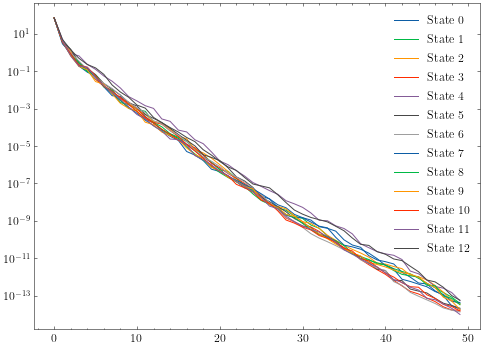

In [8]:
plt.style.use('science')
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(8, 6))
ax = plt.axes()



for i in range(sum(levels[:])):
    ax.plot(svd_coeffs[i][:50],label="State {}".format(i))
    #np.savetxt('svd_{}.out'.format(i),svd_coeffs[i][:])
plt.yscale('log')
#ax.text(170,-38.5,"K=260", fontsize=22)
#ax.text(140,-40,"K=200", fontsize=22)
#ax.set_ylim(-41,-36)
#ax.vlines(60,-50,-36,linestyle=':')

#ax.set_ylabel("Single Particle Energy (MeV)")
#ax.set_xlabel("L (MeV)")
ax.legend()


In [ ]:
global count
count = 0

start_time = time.time()
global prev_time 
prev_time = time.time()

train_num = len(train_wfs)

print("Training with {} WFs, each one with {} total states".format(train_num,sum(levels)))

ak = np.zeros((train_num,sum(levels)))
lam = np.zeros((sum(levels)))
coeffs = np.zeros((train_num*sum(levels) + sum(levels)))
#coeffs[0:train_num*sum(levels)] = 1.0/train_num
#coeffs[sum(levels):2*sum(levels)] = 0.0
coeffs[0:sum(levels)] = 1.0
coeffs[train_num*sum(levels):] = 15.0
#coeffs = sol.x
tag = "test"
directory = '/tmp/HF.'+tag
os.system("mkdir -p {directory}".format(directory=directory))
os.chdir("/home/kyle/code/GalerkinEC/EC")

os.system("cp ../HF/main {directory}/.".format(directory=directory))
#coeffs = sol.x
nmtest_params = {"E":-15.9843259547113412,"K":215.905998768288782,"SMASS":1.43365799002626937,"RHO":0.160573718963025164,"ASS":32.0099875506415614,"LASS":57.1461992412703239,"Crdr":[-76.793125,17.0058521875],"CrdJ":[-93.75,-31.25]}
#nmtest_params = {"E":-15.8,"K":220.0,"SMASS":0.992423332283364,"RHO":0.158706769332587,"ASS":28.986789057772100,"LASS":40.004790480413600,"Crdr":[-45.1351310222373,-145.382167908057],"CrdJ":[-74.0263331764599,-35.6582611147917]}
test_params = NM_to_t(nmtest_params)

print(nm_sampleparams[n])
test_params = NM_to_t(nm_sampleparams[n])
#print(nm_sampleparams[0])
#galerkin(coeffs,wfs,states,levels,test_params)
def funcOpt(xk):
    global sortstates
    global levels
    global test_params
    global directory
    global train_wfs
    res = galerkin(xk,train_wfs,sortstates,levels,test_params,directory)
    print(np.sum(res[:]**2))
    print(res)
    return
hybr_dict = {'col_deriv': 0, 'xtol': 1.49012e-30,'maxfev': 5000, 'band': None, 'eps': None, 'factor': 100, 'diag': None}
#minsol = optimize.minimize(galerkin_min,coeffs, args=(train_wfs,sortstates,levels,test_params,directory),method='Powell',callback=funcOpt,options={'disp':True,'return_all':True})
#sol = optimize.root(galerkin, coeffs, args=(train_wfs,sortstates,levels,test_params,directory), method='df-sane',options={"maxfev":1000,"disp":True,'line_search': 'cruz'})#, options=hybr_dict)
# Krylov methods: {‘lgmres’, ‘gmres’, ‘bicgstab’, ‘cgs’, ‘minres’}, default lmgres
#sol = optimize.root(galerkin, coeffs, args=(train_wfs,sortstates,levels,test_params,directory), method='krylov',options={"disp":True,"fatol":6e-6,"nit":200,'jac_options':{'method':'lgmres'}})#, options=hybr_dict)
#sol = optimize.root(galerkin, coeffs, args=(train_wfs,sortstates,levels,test_params,directory), method='lm',options={"maxiter":5000,'xtol': 1.49012e-17})#, options=hybr_dict)
sol = optimize.root(galerkin, coeffs, args=(train_wfs,sortstates,levels,test_params,directory), method='hybr', options=hybr_dict)
minsol = sol
print(minsol.x)
print(galerkin(minsol.x,train_wfs,sortstates,levels,test_params,directory))
print("Total time took: {}".format(time.time()-start_time))

Training with 4 WFs, each one with 13 total states
{'E': -14.657134355911102, 'K': 255.69360214907095, 'SMASS': 0.9425685500548943, 'RHO': 0.1488298851037109, 'ASS': 30.408531617761938, 'LASS': 58.29904661815225, 'Crdr': [-48.09510016742419, -102.55953239954803], 'CrdJ': [-60.1029790970884, -16.189105894581907]}
[ 9.99627773e-01  9.99288782e-01  9.98867243e-01  9.98835072e-01
  9.99063135e-01  9.99012456e-01  9.98000437e-01  9.98838973e-01
  9.97989711e-01  9.98637223e-01  9.98121254e-01  9.98565571e-01
  9.97485974e-01 -2.66604807e-02 -3.74806193e-02 -4.69705459e-02
 -4.77208902e-02 -4.28568641e-02 -4.11855126e-02 -5.76838270e-02
 -4.80264796e-02 -6.31961851e-02 -5.21876971e-02 -6.06097051e-02
 -5.35080758e-02 -7.05681498e-02  5.78370658e-03  1.18435292e-03
 -4.87150942e-03  2.96310308e-03 -4.67681260e-03 -1.64855337e-02
 -2.02657687e-02  3.70120459e-03 -2.47390293e-03  1.27393247e-04
 -8.72840221e-03  1.48678588e-03  6.18786872e-03  2.88266486e-04
  3.96614920e-03 -5.85384160e-03 -6.

In [ ]:
# Make the test WF with test_params
os.system("mkdir -p {directory}/results".format(directory=directory))

make_input(test_params,0,directory)
with cwd(directory):
    error = run_HF("test",0)


In [ ]:
# Make trial WF and hpsi with solved coeffs
trial_wf = make_wf(minsol.x,train_wfs,sortstates,levels)
trial_hpsi = get_hpsi_fort(test_params,h,nbox,lmax,nmax,sortstates,sortenergies,trial_wf,directory)
#print(minsol.x)
# Read in the cheated test
restartfile = directory+'/results/wf_numpy.bin.test'
h,nbox,lmax,nmax,sorts,sorte,test_wf = read_wfs(restartfile)
test_hpsi = get_hpsi_fort(test_params,h,nbox,lmax,nmax,sorts,sorte,test_wf,directory)
#test_hpsi_2 = compute_hpsi(test_params,h,nbox,lmax,nmax,sortstates,sortenergies,test_wf)
print("conv= 1e-9, h= {}".format(h))
esum = 0.0
for isospin in range(2):
        for j in range(levels[isospin]):
            i_s = sortstates[j,2,isospin]-1
            i_l = sortstates[j,1,isospin]
            i_n = sortstates[j,0,isospin]-1
            norm = np.dot(h*test_wf[:,i_n,i_l,i_s,isospin],trial_wf[:,i_n,i_l,i_s,isospin])
            #print(h*np.dot(train_wfs[0][isospin,i_s,i_l,i_n,:],trial_hpsi[isospin,i_s,i_l,i_n,:]))
            #print(h*np.dot(test_wf[isospin,i_s,i_l,i_n,:],test_wf[isospin,i_s,i_l,i_n,:]))
            trial_sp = np.dot(-h*trial_hpsi[:,i_n,i_l,i_s,isospin],trial_wf[:,i_n,i_l,i_s,isospin])
            test_sp = np.dot(-h*test_hpsi[:,i_n,i_l,i_s,isospin],test_wf[:,i_n,i_l,i_s,isospin])
            esum += abs(trial_sp-test_sp)/-test_sp
            #test_sp_2 = np.dot(-h*test_hpsi_2[isospin,i_s,i_l,i_n,:],test_wf[isospin,i_s,i_l,i_n,:])
            print("Trial: {trial:.2f} Test: {test:.2f} Difference: {diff:.2e} Norm: {norm:.4e}".format(trial=trial_sp,test=test_sp,diff=(trial_sp-test_sp)/test_sp,norm=(1.0-norm)))
print("Average error: {}".format(esum/sum(levels)))


conv= 1e-9, h= 0.01
Trial: -32.89 Test: -32.88 Difference: 2.28e-04 Norm: 6.1599e-06
Trial: -24.01 Test: -24.00 Difference: 4.59e-04 Norm: 7.7840e-06
Trial: -24.25 Test: -24.24 Difference: 2.08e-04 Norm: 4.8948e-06
Trial: -14.74 Test: -14.74 Difference: -2.38e-05 Norm: 4.3332e-06
Trial: -14.18 Test: -14.20 Difference: -1.69e-03 Norm: 1.0195e-04
Trial: -14.80 Test: -14.82 Difference: -8.08e-04 Norm: 1.3434e-05
Trial: -5.46 Test: -5.45 Difference: 1.54e-03 Norm: 2.4257e-06
Trial: -33.91 Test: -33.92 Difference: -3.35e-04 Norm: 5.5759e-07
Trial: -27.28 Test: -27.29 Difference: -2.76e-04 Norm: 2.4491e-07
Trial: -25.71 Test: -25.71 Difference: 4.73e-05 Norm: 2.2842e-07
Trial: -18.45 Test: -18.46 Difference: -5.58e-04 Norm: 5.2769e-07
Trial: -16.26 Test: -16.26 Difference: 1.14e-05 Norm: 6.4119e-07
Trial: -14.40 Test: -14.44 Difference: -2.15e-03 Norm: 5.2941e-06
Average error: 0.0006410339668583774


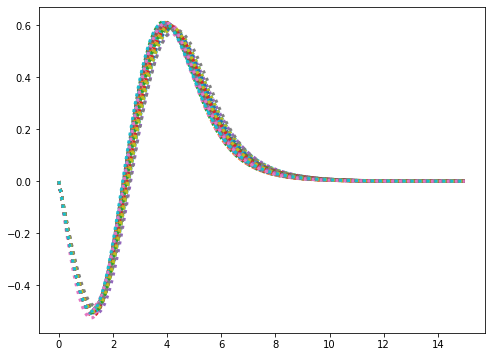

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = plt.axes()

isospin = 0
i_s = 0
i_l = 0
i_n = 1

x = np.linspace(0, 20, 2001)
#ax.plot(x[:1501],trial_wf[isospin,i_s,i_l,i_n,:1501],color='black')
for i in range(len(train_wfs)):
    #ax.plot(x[:1501],train_wfs[i][isospin,i_s,i_l,i_n,:1501]/np.linalg.norm(train_wfs[i][isospin,i_s,i_l,i_n,:1501]),linestyle=":",linewidth=3)
    ax.plot(x[:1500],train_wfs[i][:1500,i_n,i_l,i_s,isospin],linestyle=":",linewidth=3)
    #ax.plot(x[:1500],samp_wfs[i][:1500,i_n,i_l,i_s,isospin],linestyle=":",linewidth=3)
#ax.plot(x[:1501],test_wf[isospin,i_s,i_l,i_n,:1501],linestyle='--',color='red')

In [ ]:
# Let's get some stats!

samples = 500
# sampler = qmc.LatinHypercube(d=10)
# sample = sampler.random(n=samples)

# l_bounds = [-16.5, 160.0, 0.7, 0.14, 26.0, 20.0, -55.0, -165.0, -105.0, -50.0]
# u_bounds = [-14.5, 260.0, 1.4, 0.18, 32.0, 180.0, -40.0, -90.0, -55.0, -15.0]
# scaled=qmc.scale(sample, l_bounds, u_bounds)

# nm_sampleparams = []
# for param in scaled:
#         nm_sampleparams.append({"E":param[0],"K":param[1],"SMASS":param[2],"RHO":param[3],"ASS":param[4],"LASS":param[5],"Crdr":[param[6],param[7]],"CrdJ":[param[8],param[9]]})
dirs = []
sampleparams = []
hf_args = []

sample_args = [] #(coeffs,train_wfs,sortstates,levels,test_params,directory)

train_num = len(train_wfs)

print("Training with {} WFs, each one with {} total states over {} samples".format(train_num,sum(levels),samples))

ak = np.zeros((train_num,sum(levels)))
lam = np.zeros((sum(levels)))
coeffs = np.zeros((train_num*sum(levels) + sum(levels)))
#coeffs[0:train_num*sum(levels)] = 1.0/train_num
coeffs[0:sum(levels)] = 1.0
#coeffs[train_num*sum(levels):] = 15.0
coeffs[train_num*sum(levels):train_num*sum(levels)+levels[0]] = -sortenergies[:levels[0],0]
coeffs[train_num*sum(levels)+levels[0]:] = -sortenergies[:levels[1],1]
testerrors = []
nm_sampleparams = []
with open('nm_params_all.json') as f:
   for line in f:
       nm_sampleparams.append(json.loads(line))
for i in range(samples):
    directory = '/tmp/HF.{}'.format(i)
    dirs.append(directory)
    os.system("mkdir -p {directory}".format(directory=directory))
    os.system("cp ../HF/main {directory}/.".format(directory=directory))
    os.system("mkdir -p {directory}/results".format(directory=directory))
    # nmparam = nmdefault_params

    # nmparam["E"] = random.uniform(-16.5,-14.5)
    # nmparam["K"] = random.uniform(160.0,260.0)
    # nmparam["SMASS"] = random.uniform(0.7,1.4)
    # nmparam["RHO"] = random.uniform(0.14,0.18)
    # nmparam["ASS"] = random.uniform(26.0,32.0)
    # nmparam["LASS"] = random.uniform(30.0,120.0)
    # nmparam["Crdr"][0] = random.uniform(-55.0,-40.0)
    # nmparam["Crdr"][1] = random.uniform(-165.0,-90.0)
    # nmparam["CrdJ"][0] = random.uniform(-105.0,-55.0)
    # nmparam["CrdJ"][1] = random.uniform(-50.0,-15.0)
    nmparam = deepcopy(nm_sampleparams[i])
    #nm_sampleparams.append(deepcopy(nmparam))

    sampleparams.append(NM_to_t(nmparam))

    sample_args.append((coeffs,train_wfs,sortstates,levels,NM_to_t(nmparam),directory))

    hf_args.append((NM_to_t(nmparam),directory))



# with open('nm_params_all.json', 'w') as fout:
#     for dict in nm_sampleparams:
#         print(dict)
#         json.dump(dict, fout)
#         fout.write("\n")

# optimize.root(galerkin, coeffs, args=(train_wfs,sortstates,levels,test_params,directory), method='hybr', options=hybr_dict)
procs = 12
with Pool(procs) as p:
    sampled_out = p.starmap(galerkin_wrapper,sample_args)

# with Pool(procs) as p:
#     val_errors = p.starmap(hf_wrapper,hf_args)

Training with 2 WFs, each one with 13 total states over 500 samples
[[-4.41290922e+01 -4.16116502e+01]
 [-3.26254174e+01 -3.19116361e+01]
 [-2.88418448e+01 -2.89663819e+01]
 [-2.10689894e+01 -2.10798132e+01]
 [-1.60312547e+01 -1.50304860e+01]
 [-1.31910521e+01 -1.46284899e+01]
 [-9.99267469e+00  1.00000000e-25]
 [ 1.00000000e-25  1.00000000e-25]
 [ 1.00000000e-25  1.00000000e-25]
 [ 1.00000000e-25  1.00000000e-25]
 [ 1.00000000e-25  1.00000000e-25]
 [ 1.00000000e-25  1.00000000e-25]
 [ 1.00000000e-25  1.00000000e-25]
 [ 1.00000000e-25  1.00000000e-25]
 [ 1.00000000e-25  1.00000000e-25]
 [ 1.00000000e-25  1.00000000e-25]
 [ 1.00000000e-25  1.00000000e-25]
 [ 1.00000000e-25  1.00000000e-25]
 [ 1.00000000e-25  1.00000000e-25]
 [ 1.00000000e-25  1.00000000e-25]
 [ 1.00000000e-25  1.00000000e-25]
 [ 1.00000000e-25  1.00000000e-25]
 [ 1.00000000e-25  1.00000000e-25]
 [ 1.00000000e-25  1.00000000e-25]
 [ 1.00000000e-25  1.00000000e-25]
 [ 1.00000000e-25  1.00000000e-25]
 [ 1.00000000e-25  1.0

IndexError: index 312312 is out of bounds for axis 0 with size 28

In [ ]:
esp_errors = []
norm_errors = []
defdiffs = []
#optfile = open('train_4_coeffs_all.bin',mode='wb')
tradii = []
gradii = []
dradii = []
nrad_avg = 0
prad_avg = 0
ndiffrad = 0
pdiffrad = 0
os.chdir(rootdir)
goodcount = 0
#cofs = np.zeros((train_num*sum(levels) + sum(levels)))
norms = 0.0
maxe=0
for i in range(len(sampled_out)):
    # for cof in sampled_out[i].x:
    #     optfile.write(cof)
    restartfile = dirs[i]+'/results/wf_numpy.bin.test'

    noNaN = 1
    neut = 0
    conv = 1
    
    noNaN = os.system("grep -q NaN {}/results/out.test".format(dirs[i]))
    conv = os.system('grep -q "Iteration:         300" {}/results/out.test'.format(dirs[i]))
    neut = os.system('grep -q "Total Neutrons =   28.000" {}/results/out.test'.format(dirs[i]))
    neut = neut+os.system('grep -q "Total Neutrons =   27.999" {}/results/out.test'.format(dirs[i]))
    if (noNaN == 0):
        #print("NaNs in run {tag}!".format(tag=tag))
        continue
    if(conv==0):
        #print("took 300 iterations in run {tag}!".format(tag=tag))
        continue
    if(neut > 256):
        #print("Wrong number of neutrons in run {tag}!".format(tag=tag))
        continue
    goodcount += 1

    #print(galerkin(sampled_out[i].x,train_wfs,sortstates,levels,sampleparams[i],dirs[i]))
    # Make trial WF and hpsi with solved coeffs
    #cofs = np.fromfile(optfile, dtype=np.float64, count=(train_num*sum(levels) + sum(levels)), offset=i*sol.x.nbytes)
    #print(cofs)
    
    
    trial_wf = make_wf(sampled_out[i].x,train_wfs,sortstates,levels)
    #trial_wf = make_wf(cofs,train_wfs,sortstates,levels)
    trial_hpsi = get_hpsi_fort(sampleparams[i],h,nbox,lmax,nmax,sortstates,sortenergies,trial_wf,dirs[i])
    # Read in the cheated test
    restartfile = dirs[i]+'/results/wf_numpy.bin.test'

    h,nbox,lmax,nmax,sorts,sorte,test_wf = read_wfs(restartfile)
    test_hpsi = get_hpsi_fort(sampleparams[i],h,nbox,lmax,nmax,sorts,sorte,test_wf,dirs[i])
    tradii.append([radius(0,sortstates,h,test_wf),radius(1,sortstates,h,test_wf)])
    gradii.append([radius(0,sortstates,h,trial_wf),radius(1,sortstates,h,trial_wf)])
    dradii.append([radius(0,sortstates,h,wf_default),radius(1,sortstates,h,wf_default)])
    #test_hpsi_2 = compute_hpsi(test_params,h,nbox,lmax,nmax,sortstates,sortenergies,test_wf)
    ediff = 0.0
    defdiff = 0.0
    for isospin in range(2):
            for k in range(levels[isospin]):
                i_s = sortstates[k,2,isospin]-1
                i_l = sortstates[k,1,isospin]
                i_n = sortstates[k,0,isospin]-1
                norm = np.dot(h*test_wf[:,i_n,i_l,i_s,isospin],trial_wf[:,i_n,i_l,i_s,isospin])
                #print(h*np.dot(test_wf[isospin,i_s,i_l,i_n,:],test_wf[isospin,i_s,i_l,i_n,:]))
                trial_sp = np.dot(-h*trial_hpsi[:,i_n,i_l,i_s,isospin],trial_wf[:,i_n,i_l,i_s,isospin])
                test_sp = np.dot(-h*test_hpsi[:,i_n,i_l,i_s,isospin],test_wf[:,i_n,i_l,i_s,isospin])
                ediff += abs((trial_sp-test_sp)/test_sp)
                defdiff += abs((defenergies[isospin*levels[0] + k]-test_sp)/defenergies[isospin*levels[0] + k])
                norms += abs(1.0-norm)
                norm_errors.append(abs(1.0-norm))
                #test_sp_2 = np.dot(-h*test_hpsi_2[isospin,i_s,i_l,i_n,:],test_wf[isospin,i_s,i_l,i_n,:])
                #print("Trial: {trial} Test: {test} Difference: {diff} Norm: {norm}".format(trial=trial_sp,test=test_sp,diff=(trial_sp-test_sp)/trial_sp,norm=norm))
    eavg = ediff/(levels[0]+levels[1])
    j = goodcount - 1
    nrad_avg += abs((tradii[j][0]-gradii[j][0])/tradii[j][0])
    #nrad_avg += abs(((tradii[i][0]-tradii[i][1])-(gradii[i][0]-gradii[i][1]))/(tradii[i][0]-tradii[i][1]))/samples

    prad_avg += abs((tradii[j][1]-gradii[j][1])/tradii[j][1])
    ndiffrad += abs((tradii[j][0]-dradii[j][0])/dradii[j][0])
    #ndiffrad += abs(((tradii[i][0]-tradii[i][1])-(dradii[i][0]-dradii[i][1]))/(dradii[i][0]-dradii[i][1]))/samples

    pdiffrad += abs((tradii[j][1]-dradii[j][1])**2/dradii[j][1])
    #print("Average SP E Errors {}".format(eavg))
    diffavg = defdiff/(levels[0]+levels[1])
    #print("Average SP Differences {}".format(diffavg))
    defdiffs.append(diffavg)
    # if(goodcount-1 == 251):
    #     print(i,eavg)
    #     print(nm_sampleparams[i])
    if(eavg>maxe): 
        maxe = eavg
        n = i
    esp_errors.append(eavg)
    #print("Sum of Norm Errors {}".format(norms))

#optfile.close()
print("{} Total Good Runs".format(goodcount))
print("Average Norm Error: {}".format(norms/(goodcount*(levels[0]+levels[1]))))
print("Average S.P. Energy Error: {}".format(sum(esp_errors)/goodcount))
print("Average Neutron Radius Error: {}".format(nrad_avg/goodcount))
print("Average Proton Radius Error: {}".format(prad_avg/goodcount))
print("Average S.P. Energy Diff From Default: {}".format(sum(defdiffs)/goodcount))
print("Average Neutron Radius Diff From Default: {}".format(ndiffrad/goodcount))
print("Average Proton Radius Diff From Default: {}".format(pdiffrad/goodcount))


468 Total Good Runs
Average Norm Error: 0.0098523165099405
Average S.P. Energy Error: 0.010492733924287666
Average Neutron Radius Error: 0.0033542474546589176
Average Proton Radius Error: 0.003437673312159107
Average S.P. Energy Diff From Default: 0.1459364953218043
Average Neutron Radius Diff From Default: 0.021501915565349576
Average Proton Radius Diff From Default: 0.001895868598648661


0.010492733924287666
0.010155410089338438
6084
59.941493646477994
311
0.16802296484557716
0.16802296484557716
334 {'E': -14.85362093054697, 'K': 240.37407589430643, 'SMASS': 1.3854031125899158, 'RHO': 0.17842529178513047, 'ASS': 27.850635630839605, 'LASS': 179.71864600554045, 'Crdr': [-43.62601779413229, -128.65351992102057], 'CrdJ': [-69.15192824190856, -39.598025220783484]}
0.0098523165099405


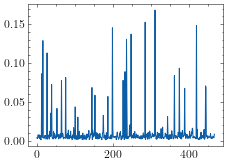

In [ ]:
fig = plt.figure()
ax = plt.axes()
ax.plot(esp_errors)
print(sum(esp_errors)/goodcount)
print((sum(esp_errors) - np.max(esp_errors))/(goodcount-1))
print((goodcount*(levels[0]+levels[1])))
print(norms)
print(np.argmax(esp_errors))
print(np.max(esp_errors))
print(maxe)
print(n,nm_sampleparams[n])
print(sum(norm_errors)/(len(norm_errors)))
